## Problem 2: Variational Quantum Eigensolver


This notebook will plot optimization trajectories obtained using the Nelder-Mead and Powell methods for different bond lengths. Then, it will perform variational quantum eigensolver (<b>VQE</b>) using pyQuil to obtain the potential energy surface of the hydrogen moleculer, similar to the result found by O'Malley and coworkers.

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

The VQE algorithm includes three steps. Start with an initial guess for $\vec{\theta}$:

(1) Prepare the ansatz.
<br>
(2) Measure the expectation $\bra{\psi}\hat{H}\ket{\psi}$.
<br>
(3) Feed the expectation values into an optimizer to obtain a new guess for $\vec{\theta}$ and repeat the steps until some convergence criterion is satisfied.

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

We will explore this problem using the research of O'Malley and coworkers as motivation. Specifically, we will simulate optimization trajectories and the potential energy surface relevant to the reduced Bravyi-Kitaev basis for the Hamiltonian of the electronic structure of molecular hydrogen. 

Thus, we consider the Hamiltonian given by
$$
\hat{H} = g_0(R) \mathbf{I} + g_1(R) \sigma_0^z + g_2(R) \sigma_1^z
        + g_3(R) \sigma_0^z \sigma_1^z + g_4(R) \sigma_0^x \sigma_1^x
        + g_5(R) \sigma_0^y \sigma_y^z
$$
where $R$ is the bond length between hydrogen atoms and each $g_i$ are coefficients determined by this bond length.

Furthermore, we used an ansatz given by
$$\ket{\psi(\theta)} = e^{-i (\theta / 2) X_0 Y_1} \ket{01}$$

Before proceeding, we will import the necessary libraries and data for our simulation.

In [1]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs
from pyquil.quil import DefGate
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = np.genfromtxt('vqe.dat', skip_header=1, dtype=None,delimiter=' ')

First, we define the ansatz function we will use for our initial guess within each simulation of the ground state wavefunction for molecular hydrogen.

In [2]:
# Prepare the ansatz, or starting function for our simulation
def ansatz(theta):
    p = Program()
    
    # First flip the second bit to convert initial |00> state to |01>
    p += X(1)
    
    # Next apply sequence of gates to reflect ansatz function
    p += H(0)
    p += RX(-np.pi/2, 1)
    p += CNOT(0, 1)
    p += RZ(theta[0], 1)
    p += CNOT(0, 1)
    p += H(0)
    p += RX(np.pi/2, 1)
    
    return p

Next, we construct optimizers that provides a new 𝜃 given the return from the objective function using both the Nelder-Mead and Powell methods.

We perform their performances at R = 0.2 angstroms. From the graphs, it seems that optimization using Nelder-Mead remains stuck at the initial guess while Powell manages to find a solution that has a much lower energy than the initial guess.  

Optimization terminated successfully.
         Current function value: 4.180481
         Iterations: 24
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 0.140592
         Iterations: 2
         Function evaluations: 41


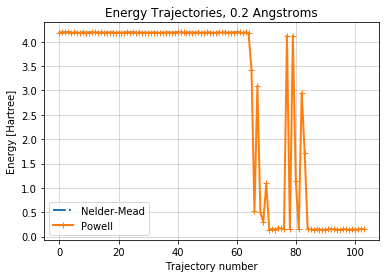

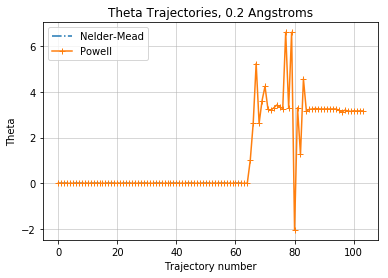

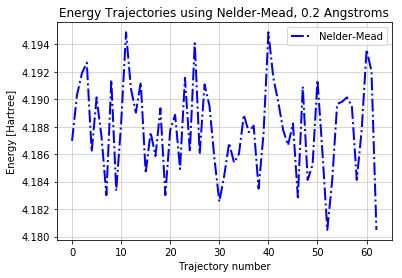

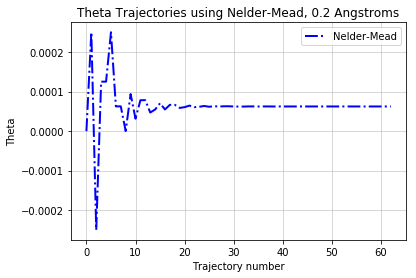

In [3]:
R = 0.2
index = round(R * 10) - 2

energy_traj_02 = []
theta_traj_02 = []

coeff = data[index,1:]

def obj(x):
    # First coefficient is <psi|I|psi> = 1, so just take the coeff[0]
    energy = coeff[0]

    # Measure ZI
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[1] * (probs[0,0] + probs[0,1] - probs[1,0] - probs[1,1])

    # Measure IZ
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[2] * (probs[0,0] + probs[1,0] - probs[0,1] - probs[1,1])

    # Measure ZZ
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[3] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])

    # Measure XX
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += H(0)
    p += H(1)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[4] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])

    # Measure YY
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += RX(-np.pi/2, 0)
    p += RX(-np.pi/2, 1)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[5] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
    
    # Update energy and theta trajectories
    energy_traj_02.append(energy)
    theta_traj_02.append(x[0])

    return energy

# Run simulation for using Nelder-Mead method
res = minimize(obj,
               x0=[0],
               method='Nelder-Mead',
               options={'maxiter': 100, 'disp': True})
energy_traj_02_nm = energy_traj_02[:]
theta_traj_02_nm = theta_traj_02[:]

# Run simulation for using Powell method
res = minimize(obj,
               x0=[0],
               method='Powell',
               options={'maxiter': 100, 'disp': True})
energy_traj_02_pw = energy_traj_02[:]
theta_traj_02_pw = theta_traj_02[:]

# With the trajectories obtained, plot the results from both methods together
%matplotlib inline  

plt.figure()
plt.plot(energy_traj_02_nm, "-.", linewidth=2)
plt.plot(energy_traj_02_pw, "-+", linewidth=2)
plt.legend(['Nelder-Mead', 'Powell'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Energy Trajectories, 0.2 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj_02_nm, "-.")
plt.plot(theta_traj_02_pw, "-+")
plt.legend(['Nelder-Mead', 'Powell'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Theta Trajectories, 0.2 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")

plt.figure()
plt.plot(energy_traj_02_nm, "-.", linewidth=2, color='blue')
plt.legend(['Nelder-Mead'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Energy Trajectories using Nelder-Mead, 0.2 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj_02_nm, "-.", linewidth=2, color='blue')
plt.legend(['Nelder-Mead'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Theta Trajectories using Nelder-Mead, 0.2 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
plt.show()

We arrived at the same conclusion when we performed the calculations using data from R = 0.6. This suggests to use Powell as the optimizer to construct the potential energy surface.

Optimization terminated successfully.
         Current function value: -1.126824
         Iterations: 2
         Function evaluations: 47


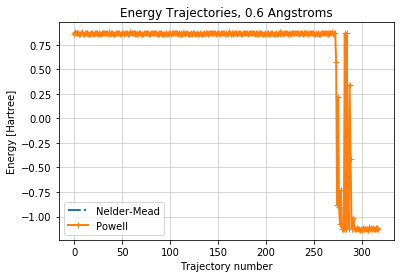

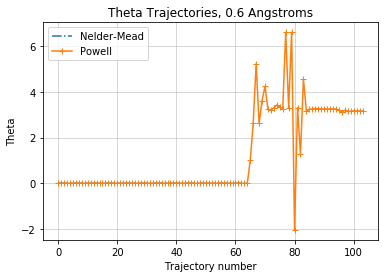

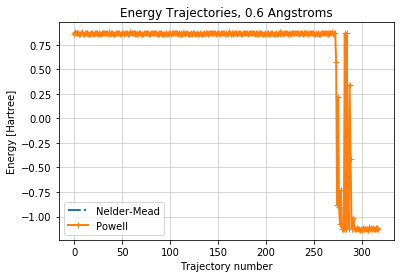

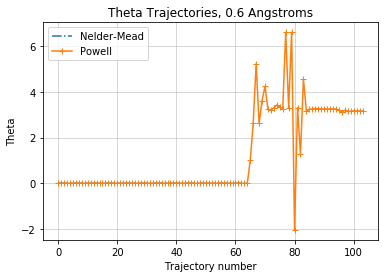

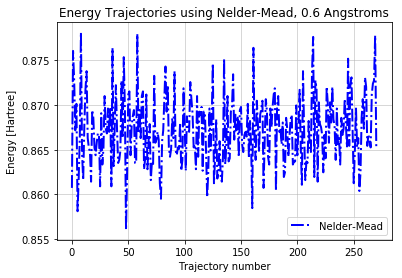

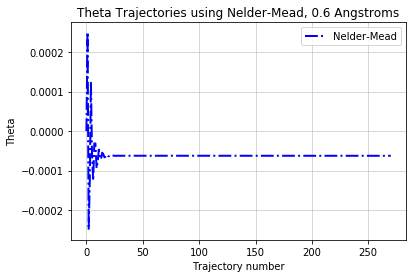

In [4]:
R = 0.6
index = round(R * 10) - 2

energy_traj_06 = []
theta_traj_06 = []

coeff = data[index,1:]

def obj(x):
    # First coefficient is <psi|I|psi> = 1. So just take the coeff[0]
    energy = coeff[0]

    # Measure ZI
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[1] * (probs[0,0] + probs[0,1] - probs[1,0] - probs[1,1])

    # Measure IZ
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[2] * (probs[0,0] + probs[1,0] - probs[0,1] - probs[1,1])

    # Measure ZZ
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[3] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])

    # Measure XX
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += H(0)
    p += H(1)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[4] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])

    # Measure YY
    p = ansatz(x)
    p.wrap_in_numshots_loop(1000)
    ro = p.declare('ro', 'BIT', 2)
    p += RX(-np.pi/2, 0)
    p += RX(-np.pi/2, 1)
    p += MEASURE(0, ro[0])
    p += MEASURE(1, ro[1])
    qc = get_qc('2q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy += coeff[5] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
    
    # Update energy and theta trajectories
    energy_traj_06.append(energy)
    theta_traj_06.append(x[0])

    return energy

# Run simulation for using Nelder-Mead method
res = minimize(obj,
               x0=[0],
               method='Nelder-Mead',
               options={'maxiter': 100, 'disp': True})
energy_traj_06_nm = energy_traj_06[:]
theta_traj_06_nm = theta_traj_06[:]

# Run simulation for using Powell method
res = minimize(obj,
               x0=[0],
               method='Powell',
               options={'maxiter': 100, 'disp': True})
energy_traj_06_pw = energy_traj_06[:]
theta_traj_06_pw = theta_traj_06[:]

# With the trajectories obtained, plot the results from both methods together
plt.figure()
plt.plot(energy_traj_06_nm, "-.", linewidth=2)
plt.plot(energy_traj_06_pw, "-+", linewidth=2)
plt.legend(['Nelder-Mead', 'Powell'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Energy Trajectories, 0.6 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj_02_nm, "-.")
plt.plot(theta_traj_02_pw, "-+")
plt.legend(['Nelder-Mead', 'Powell'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Theta Trajectories, 0.6 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
# With the trajectories obtained, plot the results from both methods together
plt.figure()
plt.plot(energy_traj_06_nm, "-.", linewidth=2)
plt.plot(energy_traj_06_pw, "-+", linewidth=2)
plt.legend(['Nelder-Mead', 'Powell'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Energy Trajectories, 0.6 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj_02_nm, "-.")
plt.plot(theta_traj_02_pw, "-+")
plt.legend(['Nelder-Mead', 'Powell'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Theta Trajectories, 0.6 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
plt.figure()
plt.plot(energy_traj_06_nm, "-.", linewidth=2, color='blue')
plt.legend(['Nelder-Mead'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Energy Trajectories using Nelder-Mead, 0.6 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj_06_nm, "-.", linewidth=2, color='blue')
plt.legend(['Nelder-Mead'])
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Theta Trajectories using Nelder-Mead, 0.6 Angstroms")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
plt.show()

(c) We perform a sweep over the bond distances to construct the potential energy surface. Based on our earlier results, we used Powell as our optimizer.:

Optimization terminated successfully.
         Current function value: 0.135375
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: -0.615245
         Iterations: 5
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -0.931060
         Iterations: 2
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -1.065809
         Iterations: 3
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: -1.133990
         Iterations: 4
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -1.155345
         Iterations: 5
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -1.146808
         Iterations: 4
         Function evaluations: 82
Optimization terminated successful

<Figure size 432x288 with 0 Axes>

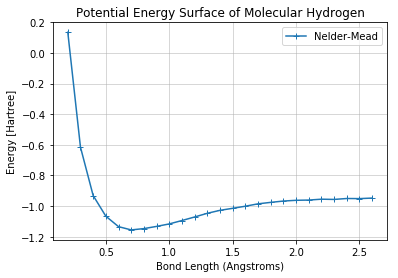

<Figure size 432x288 with 0 Axes>

In [5]:
energy_traj_pw = []

# Run the simulation for each possible bond length,
# applying the Nelder-Mead and Powell methods in optimization
for i in range(0,25):
    coeff = data[i,1:]
    
    # Construct the objective function for minimizing the potential energy
    # surface of molecular hydrogen
    def obj(x):
        # First coefficient is <psi|I|psi> = 1. So just take the coeff[0]
        energy = coeff[0]
        
        # Measure ZI
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[1] * (probs[0,0] + probs[0,1] - probs[1,0] - probs[1,1])
        
        # Measure IZ
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[2] * (probs[0,0] + probs[1,0] - probs[0,1] - probs[1,1])
        
        # Measure ZZ
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[3] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
        
        # Measure XX
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += H(0)
        p += H(1)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[4] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
        
        # Measure YY
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += RX(-np.pi/2, 0)
        p += RX(-np.pi/2, 1)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[5] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
        
        return energy
    
    # Run simulation for current bond length using Powell method
    res = minimize(obj,
                   x0=[0],
                   method='Powell',
                   options={'maxiter': 100, 'disp': True})
    energy_traj_pw.append(res.fun)
%matplotlib inline  
plt.figure()
plt.plot(data[0:25,0], energy_traj_pw, '-+')
plt.grid(linestyle='-', linewidth=0.5)
plt.legend(['Nelder-Mead', 'Powell'])
plt.title("Potential Energy Surface of Molecular Hydrogen")
plt.xlabel("Bond Length (Angstroms)")
plt.ylabel("Energy [Hartree]")
plt.figure()